# Workbook for processing WhatsApp chats 
Uses pandas for data pre-processing, HuggingFace transformers for sentiment analysis, and BERTopic to summarise topics.

This workbook analyses the Whatsapp chat established in response to the changing of Brighton schools catchment areas. The data was downloaded 16/10/24. 

In [1]:
import numpy as np
import regex
import pandas as pd
import os

from collections import Counter
import matplotlib.pyplot as plt

from transformers import BertTokenizerFast, pipeline

from umap import UMAP
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic import BERTopic

import whatsapp_processing_functions as wpf

/opt/miniconda3/envs/nlp_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the .txt file exported from the whatsapp chat

In [2]:
conversation = '/Users/bea/Documents/AI4CI/projects/brighton_schools/whatsapp_data/WhatsApp Chat with School catchment area updates/WhatsApp Chat with School catchment area updates.txt'
df = wpf.whatsapptxt_to_df(conversation)

In [3]:
df.tail()

,Date,Time,Author,Message,emoji,Message_length
1464,2024-10-16,10:44:00,+44 7950 703968,"Yes, and that’s what the new Longhill head ha...",[],323
1465,2024-10-16,10:44:00,+44 7824 353019,We should name this group Catchment gate.,[],42
1466,2024-10-16,10:48:00,+44 7835 412850,I have heard (from hearsay) she comes with a ...,[],392
1467,2024-10-16,10:51:00,+44 7950 703968,"Agreed, the underlying issues (like housing) ...",[],207
1468,2024-10-16,10:53:00,+44 7909 524938,*What’s the Catch*ment <This message was edited>,[],49


Initial analysis of user engagment with the WhatsApp chat

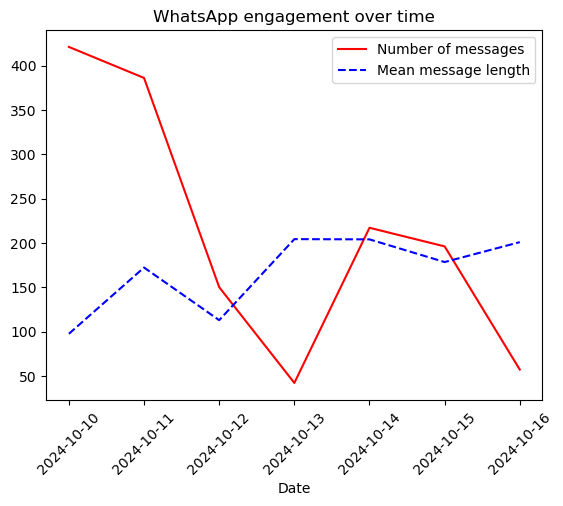

In [4]:
df_engagement = df.groupby('Date')['Message_length'].agg(['mean', 'count']).reset_index()

plt.plot(df_engagement['Date'], df_engagement['count'], label='Number of messages', linestyle='-', color='red')
plt.plot(df_engagement['Date'], df_engagement['mean'], label='Mean message length', linestyle='--', color='blue')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('WhatsApp engagement over time')
plt.legend()
plt.savefig('outputs/whatsapp_engagement.png')

In [5]:
print(f'Contributing chat members: {len(df.Author.unique())}')

Contributing chat members: 147


## Perform sentiment analysis

In [6]:
if os.path.exists('outputs/whatsapp_sentiment.csv'):
    df_sent = pd.read_csv('outputs/whatsapp_sentiment.csv')
else:
    df_sent = wpf.extract_sentiment(df)
    df_sent.to_csv('outputs/whatsapp_sentiment.csv')

In [7]:
df_sent.tail()

,Unnamed: 0,Date,Time,Author,Message,emoji,Message_length,label,score
1464,1464,2024-10-16,10:44:00,+44 7950 703968,"Yes, and that’s what the new Longhill head ha...",[],323,negative,0.997090
1465,1465,2024-10-16,10:44:00,+44 7824 353019,We should name this group Catchment gate.,[],42,neutral,0.998938
1466,1466,2024-10-16,10:48:00,+44 7835 412850,I have heard (from hearsay) she comes with a ...,[],392,positive,0.995805
1467,1467,2024-10-16,10:51:00,+44 7950 703968,"Agreed, the underlying issues (like housing) ...",[],207,neutral,0.766887
1468,1468,2024-10-16,10:53:00,+44 7909 524938,*What’s the Catch*ment <This message was edited>,[],49,neutral,0.999106


## Analyse topics using BERTopic

Before analsying the topics I first remove all repetitive messages from the chat, i.e. 'x was added', 'y left' etc. 

In [8]:
df_messages = wpf.remove_standard_messages(df_sent)

"joined using this" appears 338 times
"added" appears 53 times
"message was deleted" appears 20 times
"changed the group description" appears 6 times
"attached" appears 64 times
"\d+ left" appears 5 times


In [9]:
# this controls the representative label used for the topic
representation_model = KeyBERTInspired(top_n_words=10)

# this allows a fixed seed for reproducibility
umap = UMAP(n_neighbors=15,
            n_components=5,
            min_dist=0.0,
            low_memory=False,
            random_state=1337)

model = BERTopic(umap_model=umap, representation_model=representation_model)
topics, probs = model.fit_transform(df_messages.Message)
topic_info = model.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,325,-1_consultation_council_meeting_process,"[consultation, council, meeting, process, evid...",[ Is there an option for us to do a “free scop...
1,0,273,0_catchment_council_policy_schools,"[catchment, council, policy, schools, longhill...",[ Is Cllr Taylor actually on record making pro...
2,1,34,1_adam_adams_thankyou_thankful,"[adam, adams, thankyou, thankful, thanks, supe...","[ Incredible Adam, thank you for your work on ..."
3,2,32,2_same_too_me_here,"[same, too, me, here, im, hear, agreed, agree,...","[ Me too, Same here!, Me too]"
4,3,31,3_petition_petitions_signatures_signed,"[petition, petitions, signatures, signed, sign...",[ Feels like this petition is destined to fail...
5,4,31,4_group_meet_joined_working,"[group, meet, joined, working, admins, coordin...",[ Hi All we have 18 folks who say they would...
6,5,30,5_login_password_account_registered,"[login, password, account, registered, registr...",[ It seemed to be different to my normal BH on...
7,6,28,6_governor_resigned_resignation_deputy,"[governor, resigned, resignation, deputy, gov,...",[ He was a governor until just 3 weeks ago too...
8,7,27,7_survey_issues_initiatives_contribute,"[survey, issues, initiatives, contribute, peti...",[ Just to add too please do complete the surve...
9,8,24,8_well_damn_good_ahem,"[well, damn, good, ahem, change, not, , , , ]","[ #ahem# we're not all bad 😜, Classic FB 🤦‍♀️..."


In [10]:
# save the topics to the dataframe
df_messages['topic'] = topics

Visualise the most common topics - barchart shows top 12 topics, and the words most frequently associated with them.

In [11]:
fig1 = model.visualize_barchart(top_n_topics=12, title='Most common topics in Whatsapp chat')
fig1.write_html('outputs/whatsapp_common_topics.html')
fig1.show()

In [12]:
new_topic_labels = ['other',
 'council changing catchment',
 'thanks Adam',
 'agreement sentiment',
 'petition',
 'working group meet',
 'password login',
 'governor resigned',
 'survey of issues',
 'well damn sentiment',
 'Bella Sankey',
 'class debate',
 'complaint to council',
 'websites',
 'Tony Boland',
 'Stanford schools',
 'councillor complaint',
 'council proposals',
 'phone numbers']

topic_labels_dict = {i - 1: label for i, label in enumerate(new_topic_labels)}

model.set_topic_labels(new_topic_labels)
# model.custom_labels_

In [13]:
topic_table = topic_info[['Topic', 'Count', 'Name', 'Representative_Docs']]
topic_table['Name'] = model.custom_labels_
topic_table

,Topic,Count,Name,Representative_Docs
0,-1,325,other,[ Is there an option for us to do a “free scop...
1,0,273,council changing catchment,[ Is Cllr Taylor actually on record making pro...
2,1,34,thanks Adam,"[ Incredible Adam, thank you for your work on ..."
3,2,32,agreement sentiment,"[ Me too, Same here!, Me too]"
4,3,31,petition,[ Feels like this petition is destined to fail...
5,4,31,working group meet,[ Hi All we have 18 folks who say they would...
6,5,30,password login,[ It seemed to be different to my normal BH on...
7,6,28,governor resigned,[ He was a governor until just 3 weeks ago too...
8,7,27,survey of issues,[ Just to add too please do complete the surve...
9,8,24,well damn sentiment,"[ #ahem# we're not all bad 😜, Classic FB 🤦‍♀️..."


Visualise how the topics vary over time

In [14]:
topics_over_time = model.topics_over_time(df_messages.Message, timestamps=df_messages.Date)
fig2 = model.visualize_topics_over_time(topics_over_time, title='', custom_labels=True)
fig2.write_html('outputs/whatsapp_topics_over_time.html')
fig2.show()

## Analysing topics by sentiment 

In [15]:
df_sent_topic = df_messages.groupby(['topic','Date', 'label']).size().reset_index()
df_sent_topic.columns = ['topic', 'Date', 'label', 'count']
df_sent_topic.sort_values('Date', inplace=True)

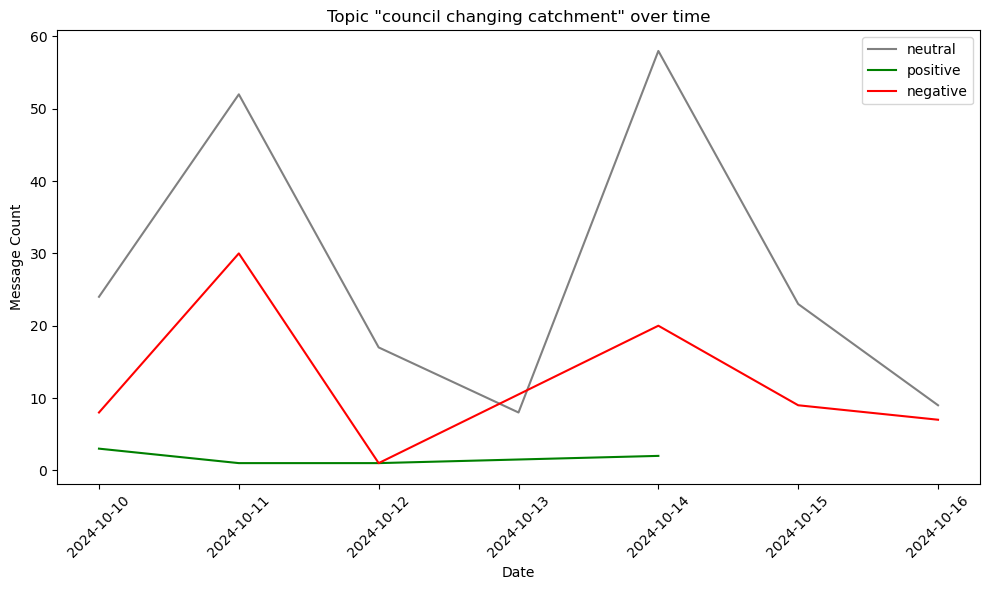

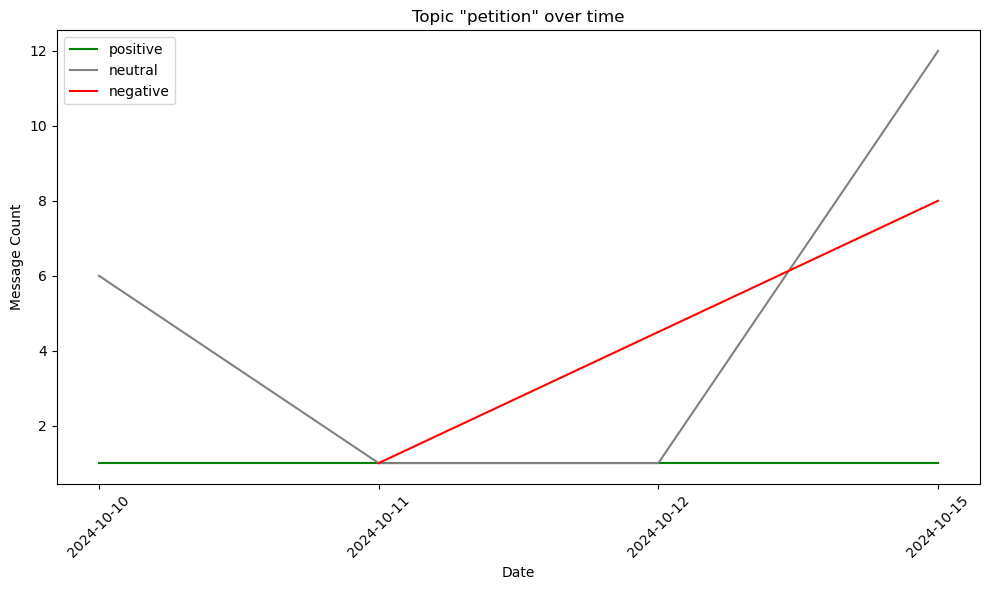

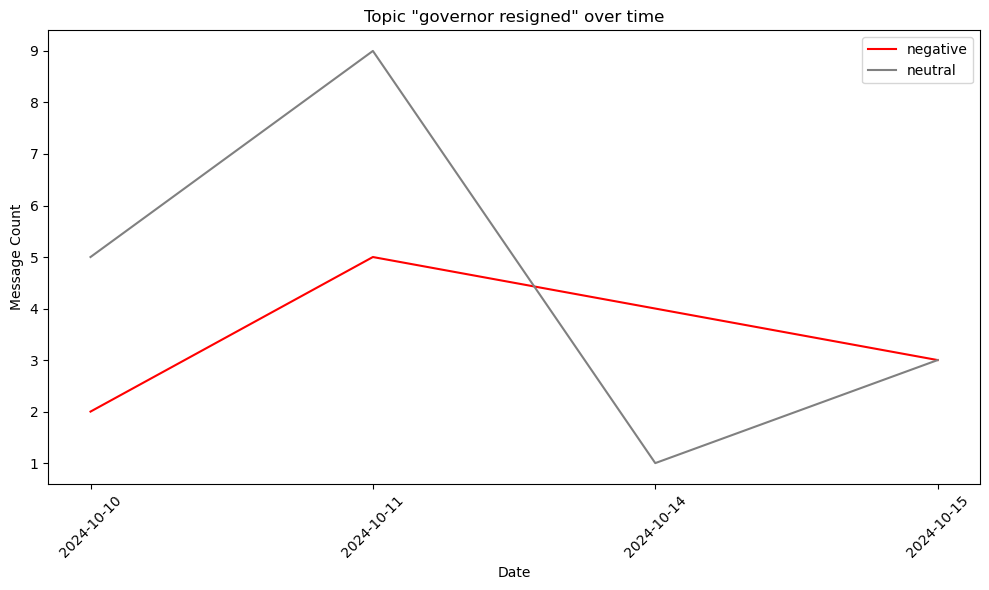

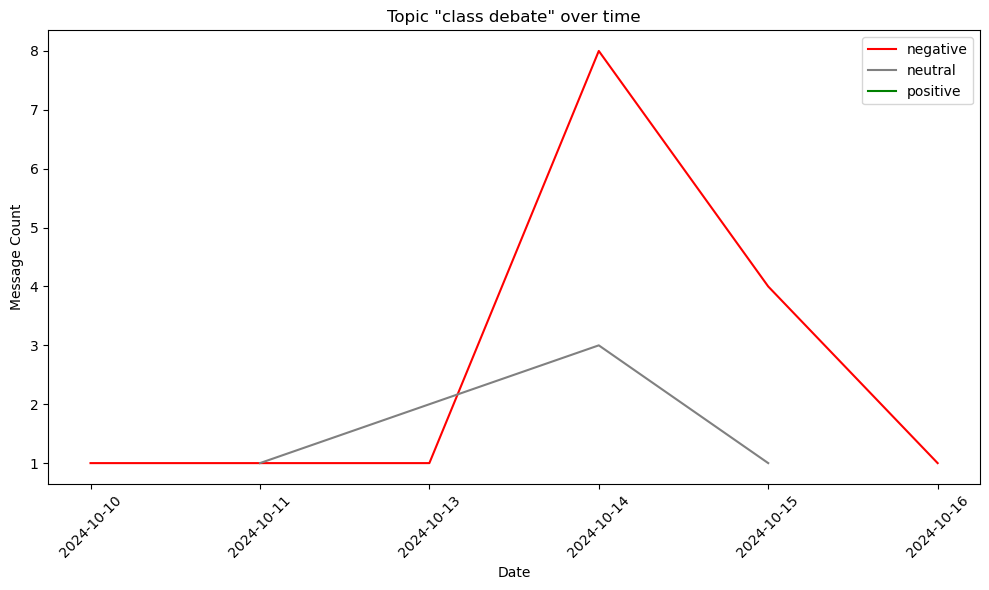

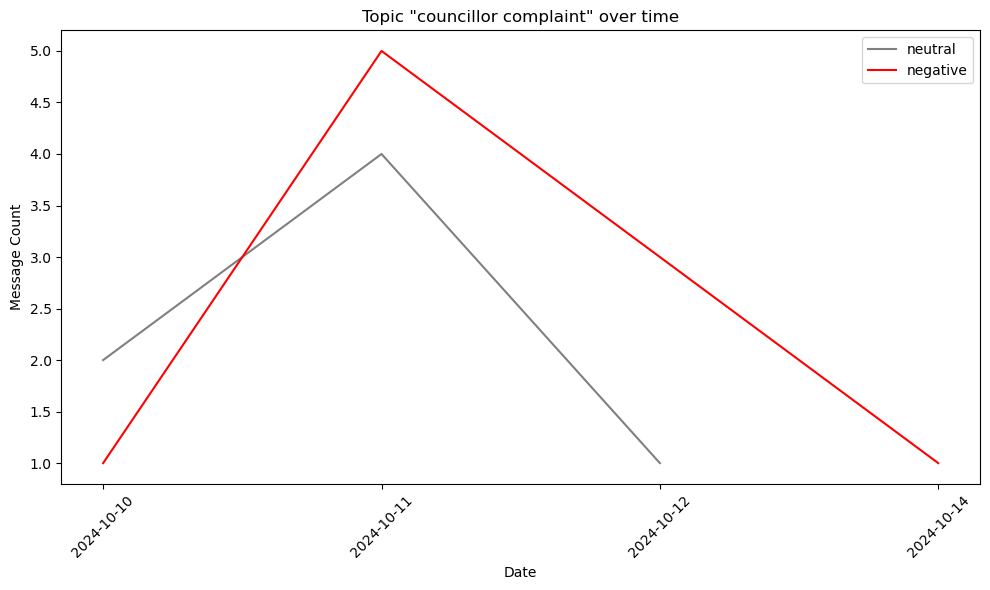

In [16]:
# Define the subset of topics to plot
subset_topics = [0, 3, 6, 10, 15]
color_dict = {'positive': 'green', 'neutral': 'grey', 'negative': 'red'}
import seaborn as sns

# Plot each topic over time stratified by sentiment
for topic in subset_topics:
    fig = plt.figure(figsize=(10, 6))

    plot_data = df_sent_topic[df_sent_topic['topic'] == topic]
    sns.lineplot(data=plot_data, x='Date', y='count', hue='label', palette=color_dict)
  
    plt.xlabel('Date')
    plt.ylabel('Message Count')
    plt.title(f'Topic "{topic_labels_dict[topic]}" over time')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()